# Advanced RAG on Hugging Face documentation using LangChain
_Authored by: [Aymeric Roucher](https://huggingface.co/m-ric)_

This notebook demonstrates how you can build an advanced RAG (Retrieval Augmented Generation) for answering a user's question about a specific knowledge base (here, the HuggingFace documentation), using LangChain.

For an introduction to RAG, you can check [this other cookbook](rag_zephyr_langchain)!

RAG systems are complex, with many moving parts: here is a RAG diagram, where we noted in blue all possibilities for system enhancement:

<img src="https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/RAG_workflow.png" height="700">

> 💡 As you can see, there are many steps to tune in this architecture: tuning the system properly will yield significant performance gains.

In this notebook, we will take a look into many of these blue notes to see how to tune your RAG system and get the best performance.

__Let's dig into the model building!__ First, we install the required model dependancies.

In [1]:
abstract1="Unreliable predictions can occur when using artificial intelligence (AI) systems with negative consequences for downstream applications, particularly when employed for decision-making. Conformal prediction provides a model-agnostic framework for uncertainty quantification that can be applied to any dataset, irrespective of its distribution, post hoc. In contrast to other pixel-level uncertainty quantification methods, conformal prediction operates without requiring access to the underlying model and training dataset, concurrently offering statistically valid and informative prediction regions, all while maintaining computational efficiency. In response to the increased need to report uncertainty alongside point predictions, we bring attention to the promise of conformal prediction within the domain of Earth Observation (EO) applications. To accomplish this, we assess the current state of uncertainty quantification in the EO domain and found that only 20% of the reviewed Google Earth Engine (GEE) datasets incorporated a degree of uncertainty information, with unreliable methods prevalent. Next, we introduce modules that seamlessly integrate into existing GEE predictive modelling workflows and demonstrate the application of these tools for datasets spanning local to global scales, including the Dynamic World and Global Ecosystem Dynamics Investigation (GEDI) datasets. These case studies encompass regression and classification tasks, featuring both traditional and deep learning-based workflows. Subsequently, we discuss the opportunities arising from the use of conformal prediction in EO. We anticipate that the increased availability of easy-to-use implementations of conformal predictors, such as those provided here, will drive wider adoption of rigorous uncertainty quantification in EO, thereby enhancing the reliability of uses such as operational monitoring and decision making"
link1="https://core.ac.uk/works/133464260/"
abstract2="This communication describes a preliminary research on detection of big masses of  plastic  (marine  litter)  on  the  oceans  and  seas  using  EO  (Earth  Observation) satellite systems. Free images from the Sentinel 2 (CopernicusProject)  platform  are  used.  To  develop  a  plastic  recognizer,  we  start  with  an image  where  we  can  find  a  big  accumulation  of “non-floating”  plastic:  Almería. We  made  a  test  using  remote  sensing  differential  indexes,  but  we  got  much better  results  using  all  available  wavelengths  (thirteen  bands)  and  applying Machine  Learning  (Neural  Networks).  Keywords  –  satellite,  Earth  Observation, Neural Networks."
link2="https://core.ac.uk/works/144838528/"
abstract3="Almost 400 researchers from across the world joined the first ECMWF–ESA Workshop on Machine Learning for Earth System Observation and Prediction (ESOP), which was hosted by ECMWF and held online from 5 to 8 October 2020. The workshop brought together experts from a variety of backgrounds to survey the status of the uptake of Machine and Deep learning (ML/DL) methodologies in the ESOP communities, evaluate their expected impacts and build a consensus view on the best way to realize the untapped potential of ML/DL in Earth System science.  Machine and Deep Learning techniques have made possible remarkable advances in an ever-growing number of disparate application areas, e.g. natural language processing, computer vision, autonomous vehicles, healthcare, finance and many others. These advances have been driven by the huge increase in available data and computing power as well as the emergence of more effective and efficient algorithms to extract relevant information from these data pools. Earth System Sciences have benefited greatly from well-known laws governing system behavior, such as the Navier-Stokes equations for fluid flow or the laws governing radiative transfer, and the success of the field has in many ways been based on its ability to translate these physical/dynamical laws into accurate numerical models. However, the field is expanding into areas that, due to the scales involved, are not easy to model from fundamental principles - this includes areas such as cloud and precipitation physics and biological processes; further there are areas where system parameters are heterogeneous on fine scales and hence are not fully-known - e.g. the Earth’s surface, its vegetation, soil and hydrological properties. Earth System Sciences have arguably been latecomers to the ML/DL party, but interest is rapidly growing, as borne out by the increasing number of publications in the field which make use of ML/DL techniques and confirmed by the large number of Accepted   for   publication   in   Bulletin   of   the   American   Meteorological   ociety.DOIS10.1175/BAMS-D-20-0307.1.Unauthenticated | Downloaded 01/14/21 02:08 PM UTC \
3 File generated with AMS Word template 1.0 participants to this workshop and to other similar events.  Innovative applications of ML/DL tools are becoming increasingly common and the workshop was structured to reflect their increasing relevance for all aspects of the Numerical Weather Prediction (NWP) and Climate Prediction workflow (Fig. 1). The following report focuses on the main discussion points and outcomes in the areas covered by the Workshop. "
link3="https://core.ac.uk/works/157345364/"

In [2]:
import pandas as pd


In [3]:
import requests
import xml.etree.ElementTree as ET

def get_arxiv_abstract(arxiv_id):
    """Fetch the abstract of a paper from arXiv using its ID."""
    # Define the arXiv API URL
    api_url = f'http://export.arxiv.org/api/query?id_list={arxiv_id}'

    # Send a GET request to the API
    response = requests.get(api_url)

    if response.status_code == 200:
        # Parse the XML response
        return parse_abstract(response.text)
    else:
        raise Exception(f"Error fetching data from arXiv: {response.status_code}")

def parse_abstract(xml_response):
    """Parse XML response to extract the abstract."""
    # Parse the XML
    root = ET.fromstring(xml_response)

    # Find the abstract in the XML structure
    for entry in root.findall('{http://www.w3.org/2005/Atom}entry'):
        abstract = entry.find('{http://www.w3.org/2005/Atom}summary')
        if abstract is not None:
            return abstract.text.strip()

    return "Abstract not found."

# Example usage
if __name__ == "__main__":
    arxiv_id = "2411.13637"  # Replace with the desired arXiv ID
    try:
        abstract = get_arxiv_abstract(arxiv_id)
        print("Abstract:")
        print(abstract)
    except Exception as e:
        print(e)

Abstract:
In light of recent observations, we study evidence for thawing quintessence
over a cosmological constant as dark energy, with emphasis on the effect of the
choice of priors. Working with a parametrization for the equation of state
parameter motivated by the theory, we find a preference for thawing
quintessence compared to a bare cosmological constant {\it only} if we use
priors which are heavily informed by the data itself. If we extend the priors
to physically better motivated ranges, the evidence for thawing quintessence
disappears.


In [4]:
data=[{"text":abstract1,"source":link1},{"text":abstract2,"source":link2},{"text":abstract3,"source":link3}]

In [5]:
!pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl pacmap datasets langchain-community ragatouille

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 29.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option(
    "display.max_colwidth", None
)  # This will be helpful when visualizing retriever outputs

### Load your knowledge base

In [10]:
RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in data
]

In [11]:
print(RAW_KNOWLEDGE_BASE)

[Document(metadata={'source': 'https://core.ac.uk/works/133464260/'}, page_content='Unreliable predictions can occur when using artificial intelligence (AI) systems with negative consequences for downstream applications, particularly when employed for decision-making. Conformal prediction provides a model-agnostic framework for uncertainty quantification that can be applied to any dataset, irrespective of its distribution, post hoc. In contrast to other pixel-level uncertainty quantification methods, conformal prediction operates without requiring access to the underlying model and training dataset, concurrently offering statistically valid and informative prediction regions, all while maintaining computational efficiency. In response to the increased need to report uncertainty alongside point predictions, we bring attention to the promise of conformal prediction within the domain of Earth Observation (EO) applications. To accomplish this, we assess the current state of uncertainty qua

# 1. Retriever - embeddings 🗂️
The __retriever acts like an internal search engine__: given the user query, it returns a few relevant snippets from your knowledge base.

These snippets will then be fed to the Reader Model to help it generate its answer.

So __our objective here is, given a user question, to find the most relevant snippets from our knowledge base to answer that question.__

This is a wide objective, it leaves open some questions. How many snippets should we retrieve? This parameter will be named `top_k`.

How long should these snippets be? This is called the `chunk size`. There's no one-size-fits-all answers, but here are a few elements:
- 🔀 Your `chunk size` is allowed to vary from one snippet to the other.
- Since there will always be some noise in your retrieval, increasing the `top_k` increases the chance to get relevant elements in your retrieved snippets. 🎯 Shooting more arrows increases your probability of hitting your target.
- Meanwhile, the summed length of your retrieved documents should not be too high: for instance, for most current models 16k tokens will probably drown your Reader model in information due to [Lost-in-the-middle phenomenon](https://huggingface.co/papers/2307.03172). 🎯 Give your reader model only the most relevant insights, not a huge pile of books!


> In this notebook, we use Langchain library since __it offers a huge variety of options for vector databases and allows us to keep document metadata throughout the processing__.

### 1.1 Split the documents into chunks

- In this part, __we split the documents from our knowledge base into smaller chunks__ which will be the snippets on which the reader LLM will base its answer.
- The goal is to prepare a collection of **semantically relevant snippets**. So their size should be adapted to precise ideas: too small will truncate ideas, and too large will dilute them.

💡 _Many options exist for text splitting: splitting on words, on sentence boundaries, recursive chunking that processes documents in a tree-like way to preserve structure information... To learn more about chunking, I recommend you read [this great notebook](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb) by Greg Kamradt._


- **Recursive chunking** breaks down the text into smaller parts step by step using a given list of separators sorted from the most important to the least important separator. If the first split doesn't give the right size or shape of chunks, the method repeats itself on the new chunks using a different separator. For instance with the list of separators `["\n\n", "\n", ".", ""]`:
    - The method will first break down the document wherever there is a double line break `"\n\n"`.
    - Resulting documents will be split again on simple line breaks `"\n"`, then on sentence ends `"."`.
    - Finally, if some chunks are still too big, they will be split whenever they overflow the maximum size.

- With this method, the global structure is well preserved, at the expense of getting slight variations in chunk size.

> [This space](https://huggingface.co/spaces/A-Roucher/chunk_visualizer) lets you visualize how different splitting options affect the chunks you get.

🔬 Let's experiment a bit with chunk sizes, beginning with an arbitrary size, and see how splits work. We use Langchain's implementation of recursive chunking with `RecursiveCharacterTextSplitter`.
- Parameter `chunk_size` controls the length of individual chunks: this length is counted by default as the number of characters in the chunk.
- Parameter `chunk_overlap` lets adjacent chunks get a bit of overlap on each other. This reduces the probability that an idea could be cut in half by the split between two adjacent chunks. We ~arbitrarily set this to 1/10th of the chunk size, you could try different values!

In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

We also have to keep in mind that when embedding documents, we will use an embedding model that accepts a certain maximum sequence length `max_seq_length`.

So we should make sure that our chunk sizes are below this limit because any longer chunk will be truncated before processing, thus losing relevancy.

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512


  0%|          | 0/7 [00:00<?, ?it/s]

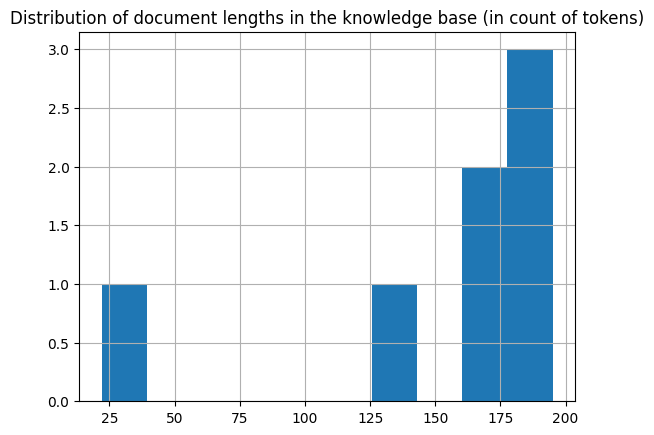

In [13]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}"
)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

👀 As you can see, __the chunk lengths are not aligned with our limit of 512 tokens__, and some documents are above the limit, thus some part of them will be lost in truncation!
 - So we should change the `RecursiveCharacterTextSplitter` class to count length in number of tokens instead of number of characters.
 - Then we can choose a specific chunk size, here we would choose a lower threshold than 512:
    - smaller documents could allow the split to focus more on specific ideas.
    - But too small chunks would split sentences in half, thus losing meaning again: the proper tuning is a matter of balance.

  0%|          | 0/10 [00:00<?, ?it/s]

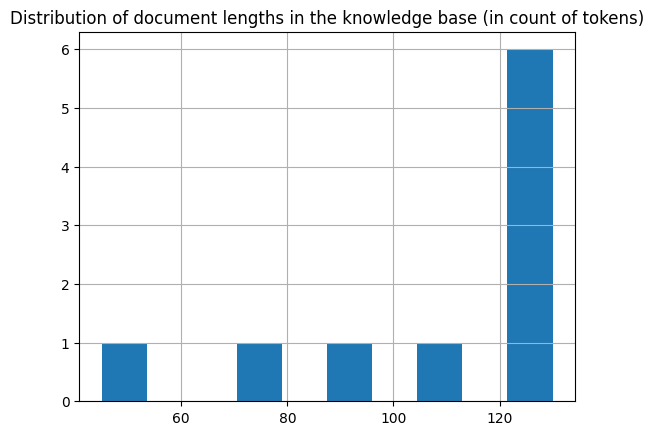

In [14]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

➡️ Now the chunk length distribution looks better!

### 1.2 Building the vector database

We want to compute the embeddings for all the chunks of our knowledge base: to learn more about sentence embeddings, we recommend reading [this guide](https://osanseviero.github.io/hackerllama/blog/posts/sentence_embeddings/).

#### How does retrieval work?

Once the chunks are all embedded, we store them in a vector database. When the user types in a query, it gets embedded by the same model previously used, and a similarity search returns the closest documents from the vector database.

The technical challenge is thus, given a query vector, to quickly find the nearest neighbors of this vector in the vector database. To do this, we need to choose two things: a distance, and a search algorithm to find the nearest neighbors quickly within a database of thousands of records.

##### Nearest Neighbor search algorithm

There are plentiful choices for the nearest neighbor search algorithm: we go with Facebook's [FAISS](https://github.com/facebookresearch/faiss) since FAISS is performant enough for most use cases, and it is well known and thus widely implemented.

##### Distances

Regarding distances, you can find a good guide [here](https://osanseviero.github.io/hackerllama/blog/posts/sentence_embeddings/#distance-between-embeddings). In short:

- **Cosine similarity** computes the similarity between two vectors as the cosinus of their relative angle: it allows us to compare vector directions regardless of their magnitude. Using it requires normalizing all vectors, to rescale them into unit norm.
- **Dot product** takes into account magnitude, with the sometimes undesirable effect that increasing a vector's length will make it more similar to all others.
- **Euclidean distance** is the distance between the ends of vectors.

You can try [this small exercise](https://developers.google.com/machine-learning/clustering/similarity/check-your-understanding) to check your understanding of these concepts. But once vectors are normalized, [the choice of a specific distance does not matter much](https://platform.openai.com/docs/guides/embeddings/which-distance-function-should-i-use).

Our particular model works well with cosine similarity, so choose this distance, and we set it up both in the Embedding model, and in the `distance_strategy` argument of our FAISS index. With cosine similarity, we have to normalize our embeddings.

🚨👇 The cell below takes a few minutes to run on A10G!

In [15]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

<ipython-input-15-86d3e6721df3>:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


👀 To visualize the search for the closest documents, let's project our embeddings from 384 dimensions down to 2 dimensions using PaCMAP.

💡 _We chose PaCMAP rather than other techniques such as t-SNE or UMAP, since [it is efficient (preserves local and global structure), robust to initialization parameters and fast](https://www.nature.com/articles/s42003-022-03628-x#Abs1)._

In [28]:
# Embed a user query in the same space
user_query = "How to use Machine learning for earth system observation and prediction?"
query_vector = embedding_model.embed_query(user_query)

In [45]:
# Embed a user query in the same space
user_query1 = "How to leverage artificial intelligence for earth observation ?"
query_vector1 = embedding_model.embed_query(user_query1)

In [29]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=1, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(
    np.array(embeddings_2d), init="pca"
)

In [30]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

<img src="https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/PaCMAP_embeddings.png" height="700">


➡️ On the graph above, you can see a spatial representation of the knowledge base documents. As the vector embeddings represent the document's meaning, their closeness in meaning should be reflected in their embedding's closeness.

The user query's embedding is also shown: we want to find the `k` documents that have the closest meaning, thus we pick the `k` closest vectors.

In the LangChain vector database implementation, this search operation is performed by the method `vector_database.similarity_search(query)`.

Here is the result:

In [31]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='How to use Machine learning for earth system observation and prediction?'...

==================================Top document==================================
Almost 400 researchers from across the world joined the first ECMWF–ESA Workshop on Machine Learning for Earth System Observation and Prediction (ESOP), which was hosted by ECMWF and held online from 5 to 8 October 2020. The workshop brought together experts from a variety of backgrounds to survey the status of the uptake of Machine and Deep learning (ML/DL) methodologies in the ESOP communities, evaluate their expected impacts and build a consensus view on the best way to realize the untapped potential of ML/DL in Earth System science.  Machine and Deep Learning techniques have made possible
==================================Metadata==================================
{'source': 'https://core.ac.uk/works/157345364/', 'start_index': 0}


# 2. Reader - LLM 💬

In this part, the __LLM Reader reads the retrieved context to formulate its answer.__

There are substeps that can all be tuned:
1. The content of the retrieved documents is aggregated together into the "context", with many processing options like _prompt compression_.
2. The context and the user query are aggregated into a prompt and then given to the LLM to generate its answer.

### 2.1. Reader model

The choice of a reader model is important in a few aspects:
- the reader model's `max_seq_length` must accommodate our prompt, which includes the context output by the retriever call: the context consists of 5 documents of 512 tokens each, so we aim for a context length of 4k tokens at least.
- the reader model

For this example, we chose [`HuggingFaceH4/zephyr-7b-beta`](https://huggingface.co/HuggingFaceH4/zephyr-7b-beta), a small but powerful model.

With many models being released every week, you may want to substitute this model to the latest and greatest. The best way to keep track of open source LLMs is to check the [Open-source LLM leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard).

To make inference faster, we will load the quantized version of the model:

In [42]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
READER_LLM("What is 4+4? Answer:")

### 2.2. Prompt

The RAG prompt template below is what we will feed to the Reader LLM: it is important to have it formatted in the Reader LLM's chat template.

We give it our context and the user's question.

In [43]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>



Let's test our Reader on our previously retrieved documents!

[-0.0336933434009552, -0.02505999244749546, 0.02288120426237583, -0.017149977385997772, 0.06657359004020691, 0.006324293557554483, 0.020525235682725906, 0.03005775809288025, 0.012267949059605598, 0.029245952144265175, 0.019732356071472168, -0.080506831407547, 0.026270482689142227, 0.01957346312701702, -0.01964028924703598, -0.003362049115821719, -0.011652343906462193, 0.06309089809656143, 0.010003526695072651, -0.0011987803736701608, 0.05110837519168854, 0.0190839022397995, -0.0688742846250534, -0.05970168486237526, 0.02126377262175083, 0.049967966973781586, -0.035912271589040756, -0.061090268194675446, -0.0633835718035698, -0.18470720946788788, 0.022630874067544937, -0.08960128575563431, 0.056836921721696854, -0.00806211493909359, -0.023828180506825447, -0.017429575324058533, -0.0005282588535919785, 0.04147501662373543, -0.05217229202389717, 0.06069894880056381, 0.001388902892358601, -0.058283306658267975, 0.014712643809616566, -0.0625607818365097, -0.01363897230476141, -0.06324212253

In [44]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

final_prompt = RAG_PROMPT_TEMPLATE.format(
    question=user_query, context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

Based on the context provided, it can be seen that the ECMWF-ESA Workshop on Machine Learning for Earth System Observation and Prediction (ESOP) aimed to explore the potential of machine learning (ML) and deep learning (DL) techniques in the fields of numerical weather prediction (NWP) and climate prediction. The workshop brought together experts from various backgrounds to evaluate the impact of ML/DL methodologies in Earth System Science and build a consensus view on how to realize their full potential.

To use ML for earth system observation and prediction, one can follow these steps:

1. Collect and prepare data: This involves gathering relevant data from various sources, such as satellites, sensors, and models, and preprocessing them to make them suitable for ML algorithms. This may involve tasks like normalization, feature engineering, and data augmentation.

2. Choose an appropriate ML algorithm: There are several types of ML algorithms, such as supervised learning, unsupervised

In [46]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

final_prompt = RAG_PROMPT_TEMPLATE.format(
    question=user_query1, context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

Based on the context provided, it is clear that the ECMWF-ESA Workshop on Machine Learning for Earth System Observation and Prediction (ESOP) aimed to explore the potential of machine and deep learning techniques in the field of earth system science. The workshop brought together experts from various backgrounds to evaluate the impact of these methodologies on earth system observations and predictions.

The workshop highlighted the use of machine learning in earth observation through two examples. Firstly, a study using remote sensing differential indexes showed promising results when all available wavelengths (thirteen bands) were used and machine learning techniques like neural networks were applied. Secondly, the workshop introduced modules that could be integrated into existing Google Earth Engine (GEE) predictive modeling workflows, demonstrating the application of these tools for datasets at both local and global scales, including the Dynamic World and Global Ecosystem Dynamics I

### 2.3. Reranking

A good option for RAG is to retrieve more documents than you want in the end, then rerank the results with a more powerful retrieval model before keeping only the `top_k`.

For this, [Colbertv2](https://arxiv.org/abs/2112.01488) is a great choice: instead of a bi-encoder like our classical embedding models, it is a cross-encoder that computes more fine-grained interactions between the query tokens and each document's tokens.

It is easily usable thanks to [the RAGatouille library](https://github.com/bclavie/RAGatouille).

In [ ]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

# 3. Assembling it all!

In [ ]:
from transformers import Pipeline


def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(
        query=question, k=num_retrieved_docs
    )
    relevant_docs = [doc.page_content for doc in relevant_docs]  # Keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join(
        [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)]
    )

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

Let's see how our RAG pipeline answers a user query.

In [ ]:
question = "how to create a pipeline object?"

answer, relevant_docs = answer_with_rag(
    question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER
)

In [ ]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

✅ We now have a fully functional, performant RAG system. That's it for today! Congratulations for making it to the end 🥳


# To go further 🗺️

This is not the end of the journey! You can try many steps to improve your RAG system. We recommend doing so in an iterative way: bring small changes to the system and see what improves performance.

### Setting up an evaluation pipeline

- 💬 "You cannot improve the model performance that you do not measure", said Gandhi... or at least Llama2 told me he said it. Anyway, you should absolutely start by measuring performance: this means building a small evaluation dataset, and then monitor the performance of your RAG system on this evaluation dataset.

### Improving the retriever

🛠️ __You can use these options to tune the results:__

- Tune the chunking method:
    - Size of the chunks
    - Method: split on different separators, use [semantic chunking](https://python.langchain.com/docs/modules/data_connection/document_transformers/semantic-chunker)...
- Change the embedding model

👷‍♀️ __More could be considered:__
- Try another chunking method, like semantic chunking
- Change the index used (here, FAISS)
- Query expansion: reformulate the user query in slightly different ways to retrieve more documents.

### Improving the reader

🛠️ __Here you can try the following options to improve results:__
- Tune the prompt
- Switch reranking on/off
- Choose a more powerful reader model

💡 __Many options could be considered here to further improve the results:__
- Compress the retrieved context to keep only the most relevant parts to answer the query.
- Extend the RAG system to make it more user-friendly:
    - cite source
    - make conversational